In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
from torch.amp import autocast, GradScaler
from efficientnet_pytorch import EfficientNet

In [2]:
# Check for GPU availability
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.current_device())  # Should return 0
print(torch.cuda.get_device_name(0))  # Should print "NVIDIA GeForce RTX 3050 Laptop GPU"

# Define constants
IMG_HEIGHT = 260  # EfficientNet-B2 default input size
IMG_WIDTH = 260   # EfficientNet-B2 default input size
BATCH_SIZE = 8    # Reduced for 4GB GPU memory
EPOCHS = 50
NUM_CLASSES = 4   # Matches your 4 classes
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
0
NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
# Define the model with EfficientNet-B2
class BrainTumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BrainTumorClassifier, self).__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b2')
        for param in self.base_model.parameters():
            param.requires_grad = False
        num_features = self.base_model._fc.in_features
        self.base_model._fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        return self.base_model(x)

In [4]:
# Data preprocessing and augmentation
def create_data_loaders(train_dir, val_dir):
    train_transforms = transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transforms = transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
    val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    return train_loader, val_loader, train_dataset.classes

In [5]:
# Training function with mixed precision
def train_model(model, train_loader, val_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scaler = GradScaler('cuda')
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            
            with autocast('cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                with autocast('cuda'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}/{EPOCHS}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    return history

In [6]:
# Plotting function
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history['train_acc'], label='Training Accuracy')
    ax1.plot(history['val_acc'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)')
    ax1.legend()
    
    ax2.plot(history['train_loss'], label='Training Loss')
    ax2.plot(history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Evaluation function
def evaluate_model(model, val_loader, class_names):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            with autocast('cuda'):
                outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [7]:
# Test a single image
def test_single_image(model_path, image_path, class_names):
    model = BrainTumorClassifier(num_classes=NUM_CLASSES)
    model.load_state_dict(torch.load(model_path))
    model.to(DEVICE)
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    from PIL import Image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        with autocast('cuda'):
            output = model(image)
        probabilities = torch.softmax(output, dim=1)[0]
        predicted_class = torch.argmax(probabilities).item()

    print("\nPrediction Results:")
    print(f"Predicted Class: {class_names[predicted_class]}")
    print("Probabilities:")
    for i, prob in enumerate(probabilities):
        print(f"{class_names[i]}: {prob:.4f}")

In [8]:
# Test multiple images
def test_multiple_images(model_path, test_dir, class_names):
    model = BrainTumorClassifier(num_classes=NUM_CLASSES)
    model.load_state_dict(torch.load(model_path))
    model.to(DEVICE)
    model.eval()

    test_loader, _, _ = create_data_loaders(test_dir, test_dir)
    evaluate_model(model, test_loader, class_names)

Loaded pretrained weights for efficientnet-b2
Using device: cuda
Epoch 1/50:
Train Loss: 0.6805, Train Acc: 73.19%
Val Loss: 0.5426, Val Acc: 79.22%
Epoch 2/50:
Train Loss: 0.5962, Train Acc: 76.75%
Val Loss: 0.5161, Val Acc: 80.22%
Epoch 3/50:
Train Loss: 0.5708, Train Acc: 77.75%
Val Loss: 0.4762, Val Acc: 81.51%
Epoch 4/50:
Train Loss: 0.5701, Train Acc: 77.82%
Val Loss: 0.4760, Val Acc: 81.74%
Epoch 5/50:
Train Loss: 0.5509, Train Acc: 78.50%
Val Loss: 0.4953, Val Acc: 79.83%
Epoch 6/50:
Train Loss: 0.5434, Train Acc: 78.89%
Val Loss: 0.4672, Val Acc: 82.30%
Epoch 7/50:
Train Loss: 0.5401, Train Acc: 79.14%
Val Loss: 0.4690, Val Acc: 80.78%
Epoch 8/50:
Train Loss: 0.5384, Train Acc: 78.86%
Val Loss: 0.4662, Val Acc: 81.34%
Epoch 9/50:
Train Loss: 0.5339, Train Acc: 79.41%
Val Loss: 0.4663, Val Acc: 81.74%
Epoch 10/50:
Train Loss: 0.5257, Train Acc: 79.77%
Val Loss: 0.4456, Val Acc: 82.24%
Epoch 11/50:
Train Loss: 0.5258, Train Acc: 79.47%
Val Loss: 0.4599, Val Acc: 82.35%
Epoch 12/

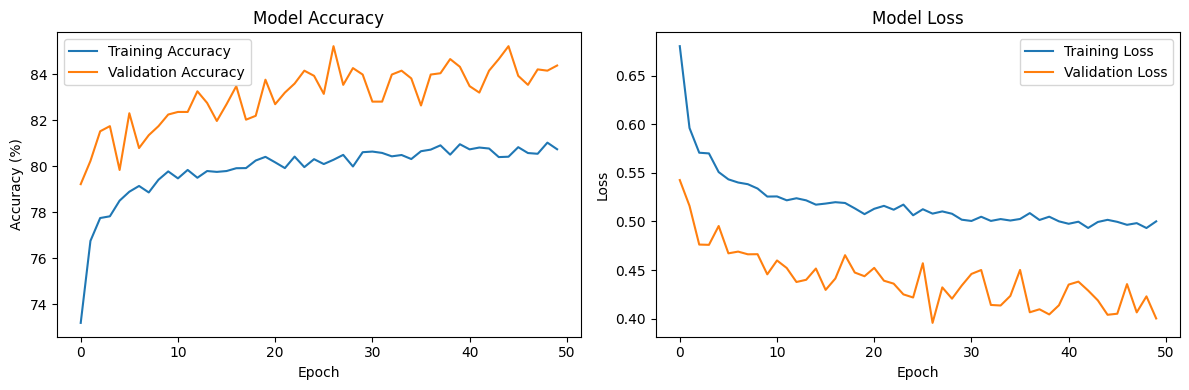


Classification Report:
              precision    recall  f1-score   support

      glioma       0.80      0.81      0.81       450
  meningioma       0.75      0.62      0.68       400
     notumor       0.94      0.97      0.95       536
   pituitary       0.83      0.94      0.88       399

    accuracy                           0.84      1785
   macro avg       0.83      0.83      0.83      1785
weighted avg       0.84      0.84      0.84      1785



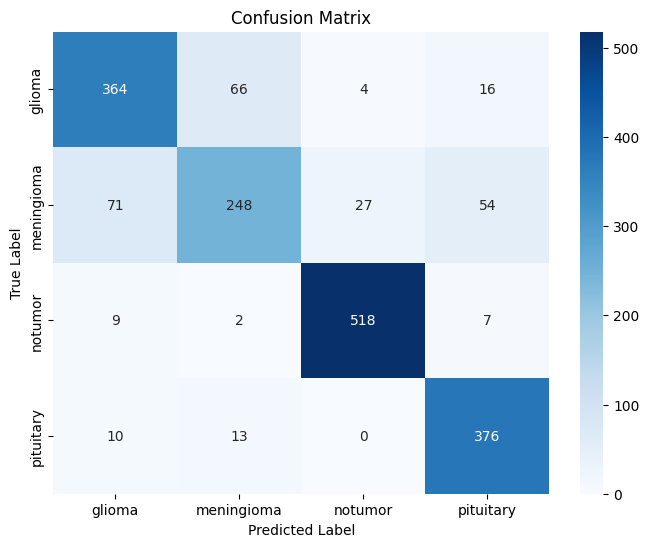

Loaded pretrained weights for efficientnet-b2


C:\Users\viraj\AppData\Local\Temp\ipykernel_31356\3451201605.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Prediction Results:
Predicted Class: notumor
Probabilities:
glioma: 0.0063
meningioma: 0.0965
notumor: 0.8882
pituitary: 0.0091


In [10]:
# Main execution
def main():
    # Define paths (update these to your actual dataset paths)
    train_dir = "C:/Users/viraj/Documents/Virajs Projects/BT DETECTION/Training"  # Replace with your actual path
    val_dir = "C:/Users/viraj/Documents/Virajs Projects/BT DETECTION/Testing"     # Replace with your actual path
    model_path = 'B2_brain_tumor_classifier.pth'
    class_names = ['glioma', 'meningioma', 'pituitary', 'no_tumor']

    # Create data loaders
    train_loader, val_loader, class_names = create_data_loaders(train_dir, val_dir)

    # Initialize and train the model
    model = BrainTumorClassifier(num_classes=NUM_CLASSES)
    model.to(DEVICE)
    print(f"Using device: {DEVICE}")
    history = train_model(model, train_loader, val_loader)

    # Save the model
    torch.save(model.state_dict(), model_path)

    # Plot training history
    plot_training_history(history)

    # Evaluate the model
    evaluate_model(model, val_loader, class_names)

    # Testing mode
    test_mode = input("Enter 'single' to test one image or 'batch' to test multiple: ").lower()
    if test_mode == 'single':
        image_path = input("Enter the path to your test image: ")
        test_single_image(model_path, image_path, class_names)
    elif test_mode == 'batch':
        test_dir = input("Enter the path to your test directory: ")
        test_multiple_images(model_path, test_dir, class_names)
    else:
        print("Invalid mode selected. Please choose 'single' or 'batch'")

if __name__ == "__main__":
    main()